# Hamilton-Jacobi Reachibility

In the following we will analyse the Hamilton-Jacobi Reachibility for a 1-dimensional coupled space, with state $\vec{x}$ and dynamics $\frac{d}{dt} \vec{x}$: 

\begin{equation}
\vec{x} = \begin{pmatrix}x\\v_x\end{pmatrix} = \begin{pmatrix}x_{robot} - x_{pedestrian}\\v_x\end{pmatrix}
\end{equation}

\begin{equation}
\frac{d}{dt}\vec{x} = \begin{pmatrix}v_x + d\\u\end{pmatrix}
\end{equation}

with $u$ being the control input applied by the robot and $d$ the disturbance, the pedestrian with single integrator dynamics. In order to be provably safe we look for the tube in that the robot's state must be in at every point in time so that no matter what the pedestrian does they both will not collide (collision is modelled here as being less or equal than one meter apart from each other).

The Hamilton-Jacobi Reachibility computes the values of a min-max game, in which the robot chooses its actions in order to avoid some set (here a tube around $\Delta x = 0$) as best as possible while the the disturbance does the oppositie, i.e. the disturbance (aka the pedestrian) tries to push the system in the avoid set. 

In [2]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.ioff()
from IPython.display import HTML

In [3]:
import numpy as np
import torch

from mantrap.agents import DoubleIntegratorDTAgent
from mantrap.environment import PotentialFieldEnvironment
from mantrap.modules import HJReachabilityModule
from mantrap.solver import SGradSolver


env = PotentialFieldEnvironment(DoubleIntegratorDTAgent, ego_kwargs={"position": torch.zeros(2)}, dt=0.4)
env.add_ado(position=torch.tensor([8, 0]), num_modes=1)
env.add_ado(position=torch.tensor([-8, 0]), num_modes=1)

module = HJReachabilityModule(env=env, t_horizon=3, weight=1.0)

### Value Function and Gradient Plot (2D slices)

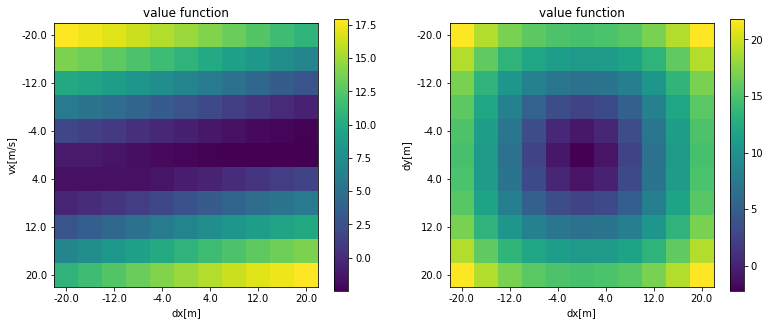

In [4]:
value_function = module.value_function
grid_min, grid_max, n = module.grid_properties
coord_zero = module._convert_state_to_value_coordinates(np.zeros(4))

plt.close('all')
fig = plt.figure(figsize=(13, 5))
x_ticks = np.arange(0, n[0] + 1, step=2)
y_ticks = np.arange(0, n[1] + 1, step=2)

plt.subplot(1, 2, 1)
im = plt.imshow(value_function[-1, :, coord_zero[1], :, coord_zero[3]])
plt.xlabel("dx[m]")
plt.ylabel("vx[m/s]")
plt.xticks(x_ticks, np.round(np.linspace(grid_min[0], grid_max[0], num=x_ticks.size), 1))
plt.yticks(y_ticks, np.round(np.linspace(grid_min[1], grid_max[1], num=y_ticks.size), 1))
plt.title("value function")
plt.colorbar(im)

plt.subplot(1, 2, 2)
im = plt.imshow(value_function[-1, :, :, coord_zero[2], coord_zero[3]])
plt.xlabel("dx[m]")
plt.ylabel("dy[m]")
plt.xticks(x_ticks, np.round(np.linspace(grid_min[0], grid_max[0], num=x_ticks.size), 1))
plt.yticks(y_ticks, np.round(np.linspace(grid_min[1], grid_max[1], num=y_ticks.size), 1))
plt.title("value function")
plt.colorbar(im)

plt.show()

In [5]:
solver = SGradSolver(env, goal=torch.rand(2), t_planning=4, modules=[(HJReachabilityModule, None)])
HTML(solver.visualize_heat_map(propagation="constant"))